In [25]:
import numpy as np
import pandas as pd
import os
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, matthews_corrcoef, f1_score, precision_score
from numpy import interp
import matplotlib.pyplot as plt
import pickle

In [30]:
# list of directories

this_dir = os.path.join(r"C:\Users\yeska\OneDrive - KU Leuven\Documents\master", "thesis\ml")
data_dir = os.path.join(this_dir, "data")
ml_vars_dir = os.path.join(data_dir, "ml_vars")
tc_v13_path = os.path.join(data_dir, "tabulated_commits_v13_nov.json")
tc_v14_path = os.path.join(data_dir, "tabulated_commits_v14_nov.json")
jit_data = "/home/deck/Documents/masterGT/mt/jit-vulnerability-prediction-master/scripts/ml_pipeline/data_for_analysis.csv"

## Read this if this is your first time in this notebook

This is not a neat notebook, might be a bit all over the place. Firstly, dont run the cells top down, its probably not gonna work. The first thing you want to run is the imports, and then the directories cell, you only need to change the "this_dir", change it to your own root directory!

Go to section 3. Final function, it contains the cell the defines the main wrapper function. Run that cell defitions, go to the defintion of the children functions and run them as well, go to the defitions of the grandchildren functions and run them, and so on. The cells that defines these functions are a bit all over the place, so here is a quick breakdown of the ones that you need to run:

- Section 1.2 contains def bool_cols_to_bin_cols(df) and def create_time_diff_col(df):
- Section 1.3 contains def balancing(df, desired_ratio)
- section 1.4 contains def feature_selection(X) and def calc_vif(X)
- section 1.6 contains def data_preprocessing(source), this is the main wrapper function as explained in the beginning of section 1. Data pre-processing
- section 2.1.1 contains def tune_hyperparameter(clf, name, cv), it's not used in the final function but you can run it if you want to test it
- section 2.2.1 contains def train_cv_save_results(clf_name, cv, X_final, y_final, save_file_name, Xy_are_np=False) and def save_variables(file_name, variables)
- section 2.3 contains def load_variables(file_name) and def load_show_metrics(file_name)
- section 3 contains def train_ml_from_file(source, clf_name, save_file_name, folds=10, repeats=1), **this is the father of all the functions, this is the one that will be used to produce ml outputs from a source file**.

## 1. Data pre-processing

1. Deal with null values
2. Non-numerical values
3. X and Y, plus balancing
4. Feature selection with VIF
5. Train, test split based on date
6. **Main function for pre-processing**, this is the most important part if you want to run things (almost) right away. go to this section and run the cell that defines data_preprocessing(...). From that cell, ensure that you run the cells that defines the functions used in data_preprocessing(...), you can simply ctrl+leftclick the function (in vscode) to go the right function definition cell.

### Quick data flattening

tabulated_commits_v13_nov.json has a dictionary in each entry, needed to be flattened. Result is tabulated_commits_v14_nov.json.These cells do not need to be run.

In [8]:

with open(tc_v13_path, 'r') as f:
    tc_v13 = json.load(f)

In [10]:
def flatten_json(json_data, parent_key='', sep='_'):
    """
    Flatten nested JSON structure
    """
    items = {}
    for k, v in json_data.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.update(flatten_json(v, new_key, sep=sep))
        else:
            items[new_key] = v
    return items

flattened_data = [flatten_json(item) for item in tc_v13]

In [11]:
with open(tc_v14_path, 'w') as f:
    json.dump(flattened_data, f, indent=4)

### 1.1. Null values dealing (and init df)
Early pandas stuff, just to get to know the data a bit. There's also a line that replaces the null values with -1

In [3]:

tc_v14_df = pd.read_json(tc_v14_path)

In [14]:
tc_v14_df.head()

,commit_sha,is_vulnerable,neutral,author_x,author_info_username,author_info_public_repos,author_info_followers,author_info_following,author_info_public_gists,author_info_created_at,...,average_loc,average_ncloc,average_dit,average_nocc,average_cbo,average_wmc,average_ccn,average_hv,oop_php_files_exist,author_info
0,349162ea139556b2d25e09e155cec84e21cc9227,False,False,ssddanbrown,ssddanbrown,74.0,372.0,20.0,44.0,2014-08-03 13:20:04+00:00,...,192.5,162.25,2.0,0.0,9.0,14.25,1.682692,358.479178,1.0,NaN
1,d41452f39c90deaca98b4fe0e8c87f7d7aa395b8,True,False,ssddanbrown,ssddanbrown,74.0,372.0,20.0,44.0,2014-08-03 13:20:04+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e639600ba5909941db97fdd3a4df4220d80f4c7a,True,False,ssddanbrown,ssddanbrown,74.0,372.0,20.0,44.0,2014-08-03 13:20:04+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,eaa1765c7a68cd671bcb37a666203210bf05d217,True,False,ssddanbrown,ssddanbrown,74.0,372.0,20.0,44.0,2014-08-03 13:20:04+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bbd1384acbe7e52c21f89af69f2dc391c95dbf54,False,False,PercussiveElbow,PercussiveElbow,28.0,26.0,28.0,8.0,2014-12-02 20:42:15+00:00,...,374.5,342.50,1.0,0.0,3.5,36.00,2.258242,333.389436,1.0,NaN


In [18]:
# There are actually quite a lot of null values

null_author_x_count = tc_v14_df['author_x'].isnull().sum()
not_null_author_x_count = tc_v14_df['author_x'].notnull().sum()

php_files_not_exist = tc_v14_df['oop_php_files_exist'].isnull().sum() + len(tc_v14_df[tc_v14_df["oop_php_files_exist"]==0])
php_files_exist = len(tc_v14_df[tc_v14_df["oop_php_files_exist"]==1])

print("total data is", len(tc_v14_df))
print("No author count", null_author_x_count)
print("Yes author count", not_null_author_x_count)
print("php files not exist (or not extracted) count", php_files_not_exist)
print("php files exist count", php_files_exist)

total data is 4096
No author count 668
Yes author count 3428
php files not exist (or not extracted) count 2219
php files exist count 1877


Since there's a lot of null values, we still don't know what to do with it, so we're going to replace it with -1 for now

In [4]:
tc_v14_df_filled = tc_v14_df.copy()
tc_v14_df_filled.fillna(-1, inplace=True)

/tmp/ipykernel_11691/1799309576.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  tc_v14_df_filled.fillna(-1, inplace=True)


### 1.2 Non-numerical processings

This is dropping some columns and changing some bool columns to binary. We also make the author creation date a time difference to the commit date.

In [3]:
# MAIN FUNCTIONS
def bool_cols_to_bin_cols(df):
    bin_cols = ["fix", "is_vulnerable", "neutral", "new_author", "oop_php_files_exist"]
    # Change binaries to 0 and 1
    for col in bin_cols:
        df[col] = df[col].astype(int)

In [60]:
def print_nonnumeric_cols(df):
    # Identify numeric columns
    numeric_columns = df.select_dtypes(include='number').columns

    # List out non-numeric columns
    non_numeric_columns = df.columns.difference(numeric_columns)

    # Print non-numeric columns
    print("Non-numeric columns:")
    for column in non_numeric_columns:
        print(column)
    

In [6]:
bin_cols = ["fix", "is_vulnerable", "neutral", "new_author", "oop_php_files_exist"]
# Change binaries to 0 and 1
for col in bin_cols:
    tc_v14_df_filled[col] = tc_v14_df_filled[col].astype(int)

the function run below is to check if there's any nonnumeric cols left

In [7]:
print_nonnumeric_cols()

Non-numeric columns:
appname
author_info_created_at
author_info_username
author_x
author_y
commit_sha
repo


This is the better version for the timezone, use it for next iterations!

In [8]:

# TIMEZONE
tc_v14_df_filled['author_info_created_at'].replace(-1, np.nan, inplace=True)
tc_v14_df_filled['author_date'] = pd.to_datetime(tc_v14_df_filled['author_date'], unit='ms')
tc_v14_df_filled['author_timezone'] = pd.to_timedelta(tc_v14_df_filled['author_timezone'], unit='s')
# Combine author_date and author_timezone to create a new column representing the actual date and time
tc_v14_df_filled['commit_time'] = tc_v14_df_filled['author_date'] + tc_v14_df_filled['author_timezone']

print("length df: ", len(tc_v14_df_filled))
print("number of unique commit SHAs: ", len(tc_v14_df_filled['commit_sha'].unique()))

# columns_to_drop = df.filter(regex='^BoW_').columns
# df_final = df.drop(columns=columns_to_drop)

tc_v14_df_filled['author_info_created_at'] = pd.to_datetime(tc_v14_df_filled['author_info_created_at'], errors='coerce', utc=True)
tc_v14_df_filled['commit_time'] = pd.to_datetime(tc_v14_df_filled['commit_time'], errors='coerce', utc=True)

tc_v14_df_filled.loc[tc_v14_df_filled['author_x'] != None, 'time_difference'] = (tc_v14_df_filled.loc[tc_v14_df_filled['author_x'] != None, 'commit_time'] - tc_v14_df_filled.loc[tc_v14_df_filled['author_x'] != None, 'author_info_created_at']).dt.days
tc_v14_df_filled['time_difference'].fillna(-1, inplace=True)

length df:  4096
number of unique commit SHAs:  4096


/tmp/ipykernel_11691/2970711136.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tc_v14_df_filled['author_info_created_at'].replace(-1, np.nan, inplace=True)
/tmp/ipykernel_11691/2970711136.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tc_v14_df_filled['author_info_created_at'].replace(-1, 

In [4]:
def create_time_diff_col(df):
    # TIMEZONE
    df['author_info_created_at'].replace(-1, np.nan, inplace=True)
    df['author_date'] = pd.to_datetime(df['author_date'], unit='ms')
    df['author_timezone'] = pd.to_timedelta(df['author_timezone'], unit='s')
    # Combine author_date and author_timezone to create a new column representing the actual date and time
    df['commit_time'] = df['author_date'] + df['author_timezone']    

    # columns_to_drop = df.filter(regex='^BoW_').columns
    # df_final = df.drop(columns=columns_to_drop)

    df['author_info_created_at'] = pd.to_datetime(df['author_info_created_at'], errors='coerce', utc=True)
    df['commit_time'] = pd.to_datetime(df['commit_time'], errors='coerce', utc=True)

    df.loc[df['author_x'] != None, 'time_difference'] = (df.loc[df['author_x'] != None, 'commit_time'] - df.loc[df['author_x'] != None, 'author_info_created_at']).dt.days
    df['time_difference'].fillna(-1, inplace=True)

In [9]:
tc_v14_df_filled = tc_v14_df_filled.drop(columns=["appname", "author_info_username", "author_x", "author_y", "commit_sha", "repo", "author_info_created_at", "author_date", "author_timezone"])
print(tc_v14_df_filled)

      is_vulnerable  neutral  author_info_public_repos  author_info_followers  \
0                 0        0                      74.0                  372.0   
1                 1        0                      74.0                  372.0   
2                 1        0                      74.0                  372.0   
3                 1        0                      74.0                  372.0   
4                 0        0                      28.0                   26.0   
...             ...      ...                       ...                    ...   
4091              0        0                      58.0                  244.0   
4092              0        0                      58.0                  244.0   
4093              0        0                      58.0                  244.0   
4094              0        0                      10.0                  108.0   
4095              0        0                      10.0                  108.0   

      author_info_following

In [10]:
print_nonnumeric_cols()

Non-numeric columns:
commit_time


commit time is kept because initially we want to split the data by date, but since we're using repeated fold cross-validation, it's gonna be kinda complicated to do that. This commit_time feature will be removed later on

### 1.3 X and Y, plus balancing

balancing here is undersampling

In [11]:
y = tc_v14_df_filled['is_vulnerable']
X = tc_v14_df_filled.drop(columns=['is_vulnerable'])
print(X.shape)
print(y.shape)

(4096, 46)
(4096,)


In [12]:
#undersampling
desired_ratio = 1 
rus = RandomUnderSampler(sampling_strategy=desired_ratio, random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)


In [20]:
print("X_resampled shape:", X_balanced.shape)
print("y_resampled shape:", y_balanced.shape)

print("vuln count", len(y_balanced[y_balanced==1]))
print("non vuln count", len(y_balanced[y_balanced==0]))

X_resampled shape: (1838, 46)
y_resampled shape: (1838,)
vuln count 919
non vuln count 919


In [5]:
def balancing(df, desired_ratio):    
    y = df['is_vulnerable']
    X = df.drop(columns=['is_vulnerable'])
    rus = RandomUnderSampler(sampling_strategy=desired_ratio, random_state=42)
    X_balanced, y_balanced = rus.fit_resample(X, y)
    return X_balanced, y_balanced

### 1.4 Feature selection with VIF

VIF removes features that have collinearity, used in palomba jit

In [6]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

def feature_selection(X):
    vif1 = calc_vif(X)
    a=vif1.VIF.max()
    while a > 5:
        maximum_a = vif1.loc[vif1['VIF'] == vif1['VIF'].max()]
        vif1 = vif1.loc[vif1['variables'] != maximum_a.iloc[0,0]]
        vif1 = calc_vif(X[vif1.variables.tolist()])
        a = vif1.VIF.max()
        # print(a)

    X = X[vif1.variables.tolist()]

    return X

In [25]:
colX = [c for c in feature_selection(X_balanced.drop(columns=['commit_time']))]

/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ss

In [26]:
print(colX)
print(len(colX))

['neutral', 'author_info_public_repos', 'author_info_followers', 'author_info_following', 'author_info_public_gists', 'days_after_creation', 'past_contributions', 'ratio_past_contributions', 'new_author', 'past_contributions_30_days', 'dmm_unit_interf', 'fix', 'past_authors', 'sum_added_lines', 'med_added_lines', 'sum_deleted_lines', 'mean_deleted_lines', 'med_deleted_lines', 'med_hunks', 'med_previous_changes', 'sum_days_since_creation', 'med_days_since_creation', 'nr_of_blacklisted', 'php_metrics_extracted', 'average_dit', 'average_cbo', 'average_wmc', 'average_hv']
28


In [28]:
colX.append('commit_time')
X_vif = X_balanced[colX]
print(X_vif.shape)

(1838, 29)


### 1.5 Train test split with date

this is ended up not used

In [46]:
def split_based_on_time(X, y, ratio):
    # Sort the DataFrame by commit_time
    data = pd.concat([X, y], axis=1)
    data = data.sort_values(by='commit_time')

    # Calculate the index for splitting
    split_index = int(len(data) * ratio)

    # Split the DataFrame into training and test sets based on the calculated index
    train_data = data.iloc[:split_index]
    test_data = data.iloc[split_index:]

    # Separate X and y for training and test sets
    X_train = train_data.drop(columns=['is_vulnerable'])  # Assuming 'commit_time' is not a feature
    y_train = train_data['is_vulnerable']
    X_test = test_data.drop(columns=['is_vulnerable'])    # Assuming 'commit_time' is not a feature
    y_test = test_data['is_vulnerable']

    return X_train, y_train, X_test, y_test

def train_val_test_split(X, y, ratio):
    X_train, y_train, X_val_test, y_val_test = split_based_on_time(X, y, ratio)
    X_val, y_val, X_test, y_test = split_based_on_time(X_val_test, y_val_test, 0.5)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [44]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_vif, y_balanced, 0.6)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1838, 30)
(736, 30)
(1102, 29) (1102,) (368, 29) (368,) (368, 29) (368,)


In [47]:
X_train.drop(columns=["commit_time"], inplace=True)
X_val.drop(columns=["commit_time"], inplace=True)
X_test.drop(columns=["commit_time"], inplace=True)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1102, 28) (1102,) (368, 28) (368,) (368, 28) (368,)


In [45]:
print(len(y_train[y_train==1]))
print(len(y_test[y_test==1]))
print(len(y_val[y_val==1]))

596
122
201


### 1.6 Main pre-processing function

this is the main function that is used in the final function for training machine learning. Its a wrapper for everything.

In [15]:
def data_preprocessing(source):
    print("Pre-processing data...")
    
    
    # Check if the file ends with .csv or .json
    if source.endswith('.csv'):
        # Read CSV file
        tc_df = pd.read_csv(source)
    elif source.endswith('.json'):
        # Read JSON file
        tc_df = pd.read_json(source)
    else:
        # If the file extension is neither .csv nor .json, raise an error
        raise ValueError("Unsupported file format. Please provide a CSV or JSON file.")
    print("Non-numerical processing")
    tc_df.fillna(-1, inplace=True) #Replace all null values with -1
    
    bool_cols_to_bin_cols(tc_df) #boolean columns to binary
    
    create_time_diff_col(tc_df) #create a time difference col that calculates the time diff between author creation and commit time
    
    tc_df = tc_df.drop(columns=["appname", #drop unused columns
                                                      "author_info_username", 
                                                      "author_x", "author_y", 
                                                      "commit_sha", "repo", 
                                                      "author_info_created_at", 
                                                      "author_date", 
                                                      "author_timezone"])
    print("Balancing...")
    X, y = balancing(tc_df, 1)
    print("Feature selection with VIF...")
    colX = [c for c in feature_selection(X.drop(columns=['commit_time']))]
    X = X[colX]
    print("Pre-processing done!\n")
    return X, y
    

In [78]:
#test the function
X_final_test, y_final_test = data_preprocessing(tc_v14_path)

Pre-processing data...
Non-numerical processing
Balancing...
Feature selection with VIF...


/tmp/ipykernel_11691/2783531626.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  tc_df.fillna(-1, inplace=True) #Replace all null values with -1
/tmp/ipykernel_11691/84237121.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['author_info_created_at'].replace(-1, np.nan, inplace=True)
/tmp/ipykernel_11691/84237121.py:3: FutureWarning

Pre-processing done!



In [84]:
print(X_final_test.shape, y_final_test.shape)
print(X_final_test.values[1427])
print(X_final_np[1427])

(1838, 28) (1838,)
[ 0.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -9.70000000e+01  3.90000000e+01  2.74647887e-01
  0.00000000e+00  2.00000000e+00  9.28151453e-01  1.00000000e+00
  3.00000000e+00  8.40120000e+04  2.50000000e+01  3.76810000e+04
  6.68102837e+01  2.10000000e+01  1.00000000e+00  1.30000000e+01
  5.03056000e+05  8.04000000e+02  1.66000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
[ 0.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -9.70000000e+01  3.90000000e+01  2.74647887e-01
  0.00000000e+00  2.00000000e+00  9.28151453e-01  1.00000000e+00
  3.00000000e+00  8.40120000e+04  2.50000000e+01  3.76810000e+04
  6.68102837e+01  2.10000000e+01  1.00000000e+00  1.30000000e+01
  5.03056000e+05  8.04000000e+02  1.66000000e+02 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]


## 2. Hyperparameter tuning, training, and show metrics

### 2.1 Hyperparameter tuning

the column commit_time is dropped here (for no good reason, but its not a big deal lol). RandomSearchCV is used for the tuning as it is used in the Palomba paper. Again simply go to the main function for hyperparameter tuning and run it if you want a (semi) plug and play

In [54]:
X_final = X_vif.drop(columns = ["commit_time"])

In [57]:
print(X_final.shape, y_balanced.shape)

(1838, 28) (1838,)


In [58]:
#classifiers = [(AdaBoostClassifier(n_estimators=100, random_state=0), "AdaBoostClassifier")]
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
n_estimators = np.arange(100, 2000, step=100)
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.5]

param_space = {
    "n_estimators": n_estimators,
    "learning_rate": learning_rate
}
random_search = RandomizedSearchCV(abc, param_space, n_iter = 10, cv = cv, scoring='f1', n_jobs=-1, random_state=0, verbose=1)

search = random_search.fit(X_final, y_balanced)

best_param = search.best_params_
best_score = search.best_score_
print(best_param)
print(best_score)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_estimators': 1900, 'learning_rate': 0.1}
0.9439919554846978


In [67]:
X_final_np = X_final.values
y_balanced_np = y_balanced.values
print(X_final_np.shape, y_balanced_np.shape)
print("Xfinal is", X_final_np)
print("yfinal is", y_balanced_np)

(1838, 28) (1838,)
Xfinal is [[  1.          20.         114.         ...   8.         171.66666667
  740.54285663]
 [  1.         302.         173.         ...  15.5         33.5
  432.51233496]
 [  1.          34.         632.         ...   0.           0.
    0.        ]
 ...
 [  0.           6.         345.         ...  -1.          -1.
   -1.        ]
 [  0.          32.           2.         ...  -1.          -1.
   -1.        ]
 [  0.           6.         345.         ...  -1.          -1.
   -1.        ]]
yfinal is [0 0 0 ... 1 1 1]


#### 2.1.1 Hyperparameter tuning: Wrapper function
run this

In [85]:
# Wrapping function for hyperparam tuning
def tune_hyperparameter(clf, name, cv):    
    if name == "AdaBoostClassifier":
        n_estimators = np.arange(100, 2000, step=100)
        learning_rate = [0.001, 0.01, 0.1, 0.2, 0.5]

        param_space = {
            "n_estimators": n_estimators,
            "learning_rate": learning_rate
        }
    else:
        raise Exception("Hyper parameter tuning param space not set for classifier", name)
    
    random_search = RandomizedSearchCV(clf, param_space, n_iter = 10, cv = cv, scoring='f1', n_jobs=-1, random_state=0, verbose=1)

    search = random_search.fit(X_final, y_balanced)

    best_param = search.best_params_
    best_score = search.best_score_
    print("the best parameters are", best_param)
    print("with (the best) score being", best_score)
    return best_param, best_score

In [86]:
# test the hyperparam tuning
abc = AdaBoostClassifier(n_estimators=100, random_state=0)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
best_param_test, best_score_test = tune_hyperparameter(abc, "AdaBoostClassifier", cv)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
the best parameters are {'n_estimators': 1900, 'learning_rate': 0.1}
with (the best) score being 0.9439919554846978


### 2.2 Training the model

the first cell is the first script that was tested to run. The cells after are the wrapper functions

In [68]:
abc_tuned = AdaBoostClassifier(n_estimators=1900, learning_rate=0.1, random_state=0)
splits_indices = cv.split(X_final_np, y_balanced_np)

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

N, P = X_final_np.shape

# Aggregate the importances over folds here:
importances_random = np.zeros(P)

# Loop over crossvalidation folds:
scores = []  # Collect accuracies here

TP = []
FP = []
TN = []
FN = []
tnList = []
fpList = []
fnList = []
tpList = []
precisionList = []
f1List = []
mccList = []

i = 1
count = 0
# for train, test in cv.split(X, y):
train_splits = []
test_splits = []
train_anomaly_percentage = []
test_anomaly_percentage = []
train_anomaly_absolute = []
test_anomaly_absolute = []
counterfold = 1
for train, test in splits_indices:
    print('Fold %s of 10' %counterfold)
    counterfold+=1
    train_splits.append(train)
    test_splits.append(test)
    count += 1

    X_train = X_final_np[train]
    y_train = y_balanced_np[train]
    X_test = X_final_np[test]
    y_test = y_balanced_np[test]

    a, b = np.unique(y_train, return_counts=True)[1]
    train_anomaly_percentage.append(b / (a + b))
    train_anomaly_absolute.append(b)
    c, d = np.unique(y_test, return_counts=True)[1]
    test_anomaly_percentage.append(d / (c + d))
    test_anomaly_absolute.append(d)

    abc_tuned.fit(X_train, y_train)

    # Predict for validation data_raw:

    
    probas_ = abc_tuned.predict_proba(X_test)
    y_pred = abc_tuned.predict(X_test)

    # Compute ROC curve and area under the curve
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1], pos_label=1)

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # calculate confusion matrix, precision, f1 and Matthews Correlation Coefficient

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    TN.append(tn)
    TP.append(tp)
    FN.append(fn)
    FP.append(fp)

    tnList.append(tn / (tn + fp))
    tpList.append(tp / (fn + tp))
    fpList.append(fp / (tn + fp))
    fnList.append(fn / (fn + tp))

    precisionList.append(precision)
    f1List.append(f1)
    mccList.append(mcc)

    i += 1
    print("\n")
    
print("confusion matrix")
tnList = 100 * np.array(tnList)
tpList = 100 * np.array(tpList)
fnList = 100 * np.array(fnList)
fpList = 100 * np.array(fpList)
precisionList = 100 * np.array(precisionList)
f1List = 100 * np.array(f1List)
mccList = 100 * np.array(mccList)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
# mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
auc_meanpercent = 100 * mean_auc
auc_stdpercent = 100 * std_auc

variables_to_save = {
    'tprs': tprs,
    'aucs': aucs,
    'N': N,
    'P': P,
    'importances_random': importances_random,
    'scores': scores,
    'TP': TP,
    'FP': FP,
    'TN': TN,
    'FN': FN,
    'tnList': tnList,
    'fpList': fpList,
    'fnList': fnList,
    'tpList': tpList,
    'precisionList': precisionList,
    'f1List': f1List,
    'mccList': mccList,
    'train_splits': train_splits,
    'test_splits': test_splits,
    'train_anomaly_percentage': train_anomaly_percentage,
    'test_anomaly_percentage': test_anomaly_percentage,
    'train_anomaly_absolute': train_anomaly_absolute,
    'test_anomaly_absolute': test_anomaly_absolute
}


Fold 1 of 10


Fold 2 of 10


Fold 3 of 10


Fold 4 of 10


Fold 5 of 10


Fold 6 of 10


Fold 7 of 10


Fold 8 of 10


Fold 9 of 10


Fold 10 of 10




#### 2.2.1 Training the model: wrapper functions

the main function is train_cv_save_results(...)

In [8]:
def save_variables(file_name, variables):
    file_path = os.path.join(ml_vars_dir, file_name)
    with open(file_path, 'wb') as handle:
        pickle.dump(variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [93]:
def train_cv_save_results(clf_name, cv, X_final, y_final, save_file_name, Xy_are_np=False):
    if not Xy_are_np:    
        X_final_np = X_final.values
        y_final_np = y_final.values
    else:
        X_final_np = X_final
        y_final_np = y_final
    if clf_name == "AdaBoostClassifier":
        clf = AdaBoostClassifier(n_estimators=1900, learning_rate=0.1, random_state=0)
    else:
        raise Exception("Clf not set for clf name", clf_name)
    splits_indices = cv.split(X_final_np, y_final_np)

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    N, P = X_final_np.shape

    # Aggregate the importances over folds here:
    importances_random = np.zeros(P)

    # Loop over crossvalidation folds:
    scores = []  # Collect accuracies here

    TP = []
    FP = []
    TN = []
    FN = []
    tnList = []
    fpList = []
    fnList = []
    tpList = []
    precisionList = []
    f1List = []
    mccList = []

    i = 1
    count = 0
    # for train, test in cv.split(X, y):
    train_splits = []
    test_splits = []
    train_anomaly_percentage = []
    test_anomaly_percentage = []
    train_anomaly_absolute = []
    test_anomaly_absolute = []
    counterfold = 1
    for train, test in splits_indices:
        print("Fold-repetition", counterfold)
        counterfold+=1
        train_splits.append(train)
        test_splits.append(test)
        count += 1

        X_train = X_final_np[train]
        y_train = y_final_np[train]
        X_test = X_final_np[test]
        y_test = y_final_np[test]

        a, b = np.unique(y_train, return_counts=True)[1]
        train_anomaly_percentage.append(b / (a + b))
        train_anomaly_absolute.append(b)
        c, d = np.unique(y_test, return_counts=True)[1]
        test_anomaly_percentage.append(d / (c + d))
        test_anomaly_absolute.append(d)

        clf.fit(X_train, y_train)

        # Predict for validation data_raw:

        
        probas_ = clf.predict_proba(X_test)
        y_pred = clf.predict(X_test)

        # Compute ROC curve and area under the curve
        
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1], pos_label=1)

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # calculate confusion matrix, precision, f1 and Matthews Correlation Coefficient

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        precision = precision_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        TN.append(tn)
        TP.append(tp)
        FN.append(fn)
        FP.append(fp)

        tnList.append(tn / (tn + fp))
        tpList.append(tp / (fn + tp))
        fpList.append(fp / (tn + fp))
        fnList.append(fn / (fn + tp))

        precisionList.append(precision)
        f1List.append(f1)
        mccList.append(mcc)

        i += 1
        print("\n")
        
    tnList = 100 * np.array(tnList)
    tpList = 100 * np.array(tpList)
    fnList = 100 * np.array(fnList)
    fpList = 100 * np.array(fpList)
    precisionList = 100 * np.array(precisionList)
    f1List = 100 * np.array(f1List)
    mccList = 100 * np.array(mccList)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    # mean_auc = auc(mean_fpr, mean_tpr)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    auc_meanpercent = 100 * mean_auc
    auc_stdpercent = 100 * std_auc

    variables_to_save = {
        'tprs': tprs,
        'aucs': aucs,
        'N': N,
        'P': P,
        'importances_random': importances_random,
        'scores': scores,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'tnList': tnList,
        'fpList': fpList,
        'fnList': fnList,
        'tpList': tpList,
        'precisionList': precisionList,
        'f1List': f1List,
        'mccList': mccList,
        'train_splits': train_splits,
        'test_splits': test_splits,
        'train_anomaly_percentage': train_anomaly_percentage,
        'test_anomaly_percentage': test_anomaly_percentage,
        'train_anomaly_absolute': train_anomaly_absolute,
        'test_anomaly_absolute': test_anomaly_absolute,
        'auc_meanpercent': auc_meanpercent,
        'auc_stdpercent' : auc_stdpercent
    }
    save_variables(save_file_name, variables_to_save)
   

In [95]:
#test train wrapper function
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
train_cv_save_results("AdaBoostClassifier", cv, X_final_test, y_final_test, "abc_k10_r1_v2.pkl")

Fold 1 of 10


Fold 2 of 10


Fold 3 of 10


Fold 4 of 10


Fold 5 of 10


Fold 6 of 10


Fold 7 of 10


Fold 8 of 10


Fold 9 of 10


Fold 10 of 10




### 2.3 Load metrics and show

The main function is load_show_metrics(...). Run that and also load_variables(...).

In [4]:
def load_variables(file_name):
    file_path = os.path.join(ml_vars_dir, file_name)
    with open(file_path, 'rb') as handle:
        loaded_variables = pickle.load(handle)    
    return loaded_variables

In [28]:
def load_show_metrics(file_name):
    print("Showing metrics for file", file_name)
    # Load variables from the file
    loaded_variables = load_variables(file_name)
    # Return each variable separately
    tprs = loaded_variables['tprs']
    aucs = loaded_variables['aucs']
    N = loaded_variables['N']
    P = loaded_variables['P']
    importances_random = loaded_variables['importances_random']
    scores = loaded_variables['scores']
    TP = loaded_variables['TP']
    FP = loaded_variables['FP']
    TN = loaded_variables['TN']
    FN = loaded_variables['FN']
    tnList = loaded_variables['tnList']
    fpList = loaded_variables['fpList']
    fnList = loaded_variables['fnList']
    tpList = loaded_variables['tpList']
    precisionList = loaded_variables['precisionList']
    f1List = loaded_variables['f1List']
    mccList = loaded_variables['mccList']
    train_splits = loaded_variables['train_splits']
    test_splits = loaded_variables['test_splits']
    train_anomaly_percentage = loaded_variables['train_anomaly_percentage']
    test_anomaly_percentage = loaded_variables['test_anomaly_percentage']
    train_anomaly_absolute = loaded_variables['train_anomaly_absolute']
    test_anomaly_absolute = loaded_variables['test_anomaly_absolute']
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    auc_meanpercent = 100 * mean_auc
    auc_stdpercent = 100 * std_auc
    
    """Show metrics"""
    
    plt.clf()  # Clear the current figure
    
    print("TN: %.02f %% ± %.02f %% - FN: %.02f %% ± %.02f %%" % (np.mean(tnList),
                                                                    np.std(tnList),
                                                                    np.mean(fnList),
                                                                    np.std(fnList)))
    print("FP: %.02f %% ± %.02f %% - TP: %.02f %% ± %.02f %%" % (np.mean(fpList),
                                                                    np.std(fpList),
                                                                    np.mean(tpList),
                                                                    np.std(tpList)))

    print(
        "Precision: %.02f %% ± %.02f %% - F1: %.02f %% ± %.02f %% - MCC: %.02f %% ± %.02f %%" % (np.mean(precisionList),
                                                                                                    np.std(precisionList),
                                                                                                    np.mean(f1List),
                                                                                                    np.std(f1List),
                                                                                                    np.mean(mccList),
                                                                                                    np.std(mccList)))

    print("AUC: %.02f %% ± %.02f %%" % (auc_meanpercent, auc_stdpercent))
    # plt.figure(1)  # Create a new figure
    # plt.plot(mean_fpr, mean_tpr, color='b',
    #             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
    #             lw=2, alpha=.8)

    # std_tpr = np.std(tprs, axis=0)
    # tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    # tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
    #                     label=r'$\pm$ 1 std. dev.')

    # xlim = [-0.05, 1.05]
    # ylim = [-0.05, 1.05]
    # plt.xlim(xlim)
    # plt.ylim(ylim)
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend(loc="lower right")
    # plt.show()


In [33]:
# test show load metrics wrapper func
load_show_metrics("abc_k10_r1_v1.pkl")
load_show_metrics("abc_k5_r5_v1.pkl")

Showing metrics for file abc_k10_r1_v1.pkl
TN: 92.49 % ± 2.82 % - FN: 3.91 % ± 1.83 %
FP: 7.51 % ± 2.82 % - TP: 96.09 % ± 1.83 %
Precision: 92.84 % ± 2.43 % - F1: 94.40 % ± 1.23 % - MCC: 88.70 % ± 2.54 %
AUC: 98.48 % ± 0.57 %
Showing metrics for file abc_k5_r5_v1.pkl
TN: 96.95 % ± 1.19 % - FN: 0.65 % ± 0.65 %
FP: 3.05 % ± 1.19 % - TP: 99.35 % ± 0.65 %
Precision: 97.04 % ± 1.13 % - F1: 98.17 % ± 0.77 % - MCC: 96.33 % ± 1.55 %
AUC: 99.75 % ± 0.25 %


<Figure size 640x480 with 0 Axes>

TN: 92.49 % ± 2.82 % - FN: 3.91 % ± 1.83 %
FP: 7.51 % ± 2.82 % - TP: 96.09 % ± 1.83 %
Precision: 92.84 % ± 2.43 % - F1: 94.40 % ± 1.23 % - MCC: 88.70 % ± 2.54 %
AUC: 98.48 % ± 0.57 %


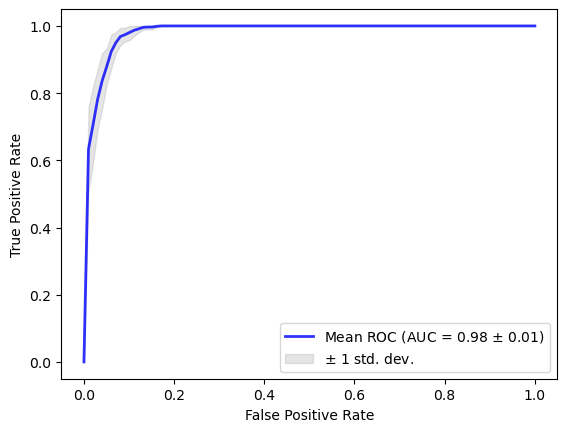

In [70]:

"""Show metrics"""

print("TN: %.02f %% ± %.02f %% - FN: %.02f %% ± %.02f %%" % (np.mean(tnList),
                                                                np.std(tnList),
                                                                np.mean(fnList),
                                                                np.std(fnList)))
print("FP: %.02f %% ± %.02f %% - TP: %.02f %% ± %.02f %%" % (np.mean(fpList),
                                                                np.std(fpList),
                                                                np.mean(tpList),
                                                                np.std(tpList)))

print(
    "Precision: %.02f %% ± %.02f %% - F1: %.02f %% ± %.02f %% - MCC: %.02f %% ± %.02f %%" % (np.mean(precisionList),
                                                                                                np.std(precisionList),
                                                                                                np.mean(f1List),
                                                                                                np.std(f1List),
                                                                                                np.mean(mccList),
                                                                                                np.std(mccList)))

print("AUC: %.02f %% ± %.02f %%" % (auc_meanpercent, auc_stdpercent))
plt.figure(1)
plt.clf()

plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

xlim = [-0.05, 1.05]
ylim = [-0.05, 1.05]
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

## 3. Final function

This is the main dish, its the ultra main function that wraps everything. It takes the file, what kind of classifier you want (right now it only supports adaboost), outputfile name, and some cv settings. Run the "def train_ml_from_file(...)" cell, and go to the child functions and run their definition cells as well, and run the children functions of those children functions and so on.

In [16]:
def train_ml_from_file(source, clf_name, save_file_name, folds=10, repeats=1):
    X_final, y_final = data_preprocessing(source)
    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=1)
    train_cv_save_results(clf_name, cv, X_final, y_final, save_file_name)
    load_show_metrics(save_file_name)

Pre-processing data...
Non-numerical processing


/tmp/ipykernel_11691/2783531626.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  tc_df.fillna(-1, inplace=True) #Replace all null values with -1
/tmp/ipykernel_11691/84237121.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['author_info_created_at'].replace(-1, np.nan, inplace=True)
/tmp/ipykernel_11691/84237121.py:3: FutureWarning

Balancing...
Feature selection with VIF...


/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ss

Pre-processing done!

Fold-repetition 1


Fold-repetition 2


Fold-repetition 3


Fold-repetition 4


Fold-repetition 5


Fold-repetition 6


Fold-repetition 7


Fold-repetition 8


Fold-repetition 9


Fold-repetition 10


Fold-repetition 11


Fold-repetition 12


Fold-repetition 13


Fold-repetition 14


Fold-repetition 15


Fold-repetition 16


Fold-repetition 17


Fold-repetition 18


Fold-repetition 19


Fold-repetition 20


Fold-repetition 21


Fold-repetition 22


Fold-repetition 23


Fold-repetition 24


Fold-repetition 25


Showing metrics for file abc_k5_r5_v1.pkl
TN: 96.95 % ± 1.19 % - FN: 0.65 % ± 0.65 %
FP: 3.05 % ± 1.19 % - TP: 99.35 % ± 0.65 %
Precision: 97.04 % ± 1.13 % - F1: 98.17 % ± 0.77 % - MCC: 96.33 % ± 1.55 %
AUC: 98.48 % ± 0.57 %


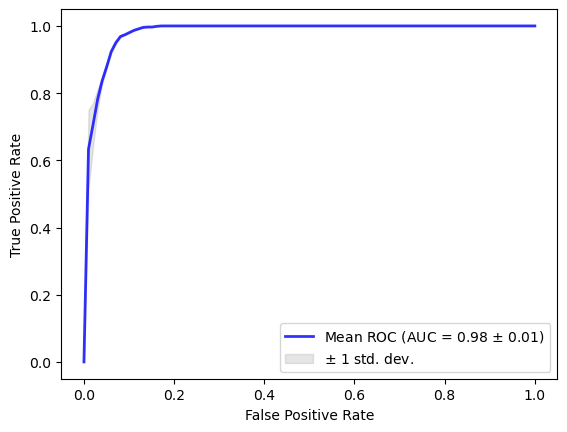

In [137]:
train_ml_from_file(tc_v14_path, "AdaBoostClassifier", "abc_k5_r5_v1.pkl", folds=5, repeats=5)

## 4. Sanity testing using other datasets

Since the result is suspiciously good, we want to check if the code is faulty or not by testing it against other datasets and compare results. The main code that is tested here is train_cv_save_results(...). The data_preprocessing is not really tested here because well we're using other datasets.

### The JIT palomba dataset

In [73]:
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from collections import Counter

def calc_vif_jit(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

def feature_selection_jit(data, colX, subset):
    
    X = data[colX]
    vif1 = calc_vif_jit(X)
    a=vif1.VIF.max()
    while a > 5:
        maximum_a = vif1.loc[vif1['VIF'] == vif1['VIF'].max()]
        vif1 = vif1.loc[vif1['variables'] != maximum_a.iloc[0,0]]
        vif1 = calc_vif_jit(X[vif1.variables.tolist()])
        a = vif1.VIF.max()
        # print(a)

    X = data[vif1.variables.tolist()]
    
    return X

def jit_data_preprocessing(subset, oversampling):
    # Read in data_raw and create the variable df to manipulate it
    df = pd.read_csv(jit_data, low_memory=False)

    # remove infinite values and NaN values
    df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
    # variables assignement
    y = df['contributing']
    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(y).ravel()
    if subset == 'CK':
        colX = [c for c in feature_selection_jit(df, [c for c in df.columns if "CK_" in c], subset)]
    if subset == 'PROCESS':
        colX = [c for c in feature_selection_jit(df, [c for c in df.columns if "P_" in c], subset)]
    if subset == 'TEXT':
        colX = [c for c in df.columns if "T_" in c]
    if subset == 'PROCESS-TEXT':
        colX = [c for c in feature_selection_jit(df, [c for c in df.columns if "P_" in c], subset)] + [c for c in df.columns if "T_" in c]
    if subset == 'CK-TEXT':
        colX = [c for c in feature_selection_jit(df, [c for c in df.columns if "CK_" in c], subset)] + [c for c in df.columns if "T_" in c]
    if subset == 'CK-PROCESS':
        df['PROCESS_fix'] = df['PROCESS_fix'].astype(int)
        colX = [c for c in feature_selection_jit(df, [c for c in df.columns if "PRODUCT_" in c or "PROCESS_" in c], subset)]
        
    if subset == 'ALL':
        colX = [c for c in feature_selection_jit(df, [c for c in df.columns if "CK_" in c or "P_" in c], subset)] + [c for c in df.columns if "T_" in c]

    groups = np.array(df['project'])

    projects = np.unique(groups)

    projects.sort()
    j = 1
    input_list = []
    target_list = []
    group_list = []
    for i in projects:
        a = df[df.project.isin([i])]
        a = a.sort_index(axis=0, inplace=False)
        a_scaled = a[colX]
        y = a['contributing']
        lb = preprocessing.LabelBinarizer()
        y = lb.fit_transform(y).ravel()


        if oversampling == True:
            if Counter(y)[1] > 1:
                sm = SMOTE(random_state=0, n_jobs=-1, k_neighbors=1)
                a_scaled, y = sm.fit_resample(a_scaled, y)


        group_list.append([i]*len(y))
        target_list.append(y)
        input_list.append(a_scaled)
        j += 1

    X = np.concatenate(input_list)
    y = np.concatenate(target_list)
    groups = np.concatenate(group_list)
    return X, y, groups, colX

In [23]:
df_jit = pd.read_csv(jit_data, low_memory=False)

In [31]:

df_jit.head
print("JIT total length", len(df_jit))
print("JIT vuln contributing count", len(df_jit[df_jit["contributing"] == 1]))

JIT total length 8991
JIT vuln contributing count 90


In [74]:
X_jit, y_jit, groups_jit, colX_jit = jit_data_preprocessing('CK-PROCESS', True)
print(X_jit.shape)
print(y_jit.shape)
print(groups_jit.shape)
print('Using: %s' %colX_jit)

/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 -

(17606, 36)
(17606,)
(17606,)
Using: ['PRODUCT_mean_sloc', 'PRODUCT_mean_dit', 'PRODUCT_mean_noc', 'PRODUCT_mean_sloc.1', 'PRODUCT_mean_wmc.1', 'PRODUCT_mean_cbo.1', 'PRODUCT_mean_rfc.1', 'PRODUCT_mean_dit.1', 'PRODUCT_MEANmean_noc', 'PRODUCT_mean_loc.2', 'PRODUCT_mean_sloc.2', 'PRODUCT_mean_wmc.2', 'PRODUCT_mean_cbo.2', 'PRODUCT_mean_rfc.2', 'PRODUCT_mean_dit.2', 'PRODUCT_MEANmean_noc.1', 'PRODUCT_mean_lcom1', 'PRODUCT_mean_lcom2', 'PROCESS_days_after_creation', 'PROCESS_past_contributions', 'PROCESS_ratio_past_contributions', 'PROCESS_past_contributions_30_days', 'PROCESS_fix', 'PROCESS_touched_files', 'PROCESS_entropy', 'PROCESS_past_authors', 'PROCESS_sum_added_lines', 'PROCESS_sum_deleted_lines', 'PROCESS_sum_added_methods', 'PROCESS_sum_deleted_methods', 'PROCESS_sum_changed_methods', 'PROCESS_sum_added_calls', 'PROCESS_sum_added_assignments', 'PROCESS_sum_removed_assignments', 'PROCESS_sum_hunks', 'PROCESS_mean_previous_changes']


In [82]:
X_jit_osf, y_jit_osf, groups_jit_osf, colX_jit_osf = jit_data_preprocessing('CK-PROCESS', False) #osf means oversampling false
print(X_jit.shape)
print(y_jit.shape)
print(groups_jit.shape)
print('Using: %s' %colX_jit)

/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 -

(17606, 36)
(17606,)
(17606,)
Using: ['PRODUCT_mean_sloc', 'PRODUCT_mean_dit', 'PRODUCT_mean_noc', 'PRODUCT_mean_sloc.1', 'PRODUCT_mean_wmc.1', 'PRODUCT_mean_cbo.1', 'PRODUCT_mean_rfc.1', 'PRODUCT_mean_dit.1', 'PRODUCT_MEANmean_noc', 'PRODUCT_mean_loc.2', 'PRODUCT_mean_sloc.2', 'PRODUCT_mean_wmc.2', 'PRODUCT_mean_cbo.2', 'PRODUCT_mean_rfc.2', 'PRODUCT_mean_dit.2', 'PRODUCT_MEANmean_noc.1', 'PRODUCT_mean_lcom1', 'PRODUCT_mean_lcom2', 'PROCESS_days_after_creation', 'PROCESS_past_contributions', 'PROCESS_ratio_past_contributions', 'PROCESS_past_contributions_30_days', 'PROCESS_fix', 'PROCESS_touched_files', 'PROCESS_entropy', 'PROCESS_past_authors', 'PROCESS_sum_added_lines', 'PROCESS_sum_deleted_lines', 'PROCESS_sum_added_methods', 'PROCESS_sum_deleted_methods', 'PROCESS_sum_changed_methods', 'PROCESS_sum_added_calls', 'PROCESS_sum_added_assignments', 'PROCESS_sum_removed_assignments', 'PROCESS_sum_hunks', 'PROCESS_mean_previous_changes']


In [83]:

def count_label_occurrences(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique_labels, counts))
    return label_counts

count_label_occurrences(y_jit_osf)

{0: 8901, 1: 90}

In [95]:
cv_jit = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
train_cv_save_results("AdaBoostClassifier", cv_jit, X_jit_osf, y_jit_osf, "jit_process_product_k10_r1_oversamp_false.pkl", True)

Fold-repetition 1


Fold-repetition 2


Fold-repetition 3


Fold-repetition 4


/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Fold-repetition 5


Fold-repetition 6


Fold-repetition 7


/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Fold-repetition 8


Fold-repetition 9


/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




Fold-repetition 10




/home/deck/anaconda3/envs/MTML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
load_show_metrics("jit_process_product_k10_r1_oversamp_true.pkl")

Showing metrics for file jit_process_product_k10_r1_oversamp_true.pkl
TN: 94.41 % ± 0.47 % - FN: 1.10 % ± 0.28 %
FP: 5.59 % ± 0.47 % - TP: 98.90 % ± 0.28 %
Precision: 94.53 % ± 0.42 % - F1: 96.67 % ± 0.20 % - MCC: 93.35 % ± 0.41 %
AUC: 99.40 % ± 0.14 %


<Figure size 640x480 with 0 Axes>

In [35]:
load_show_metrics("jit_process_product_k10_r1_oversamp_false.pkl")

Showing metrics for file jit_process_product_k10_r1_oversamp_false.pkl
TN: 99.96 % ± 0.07 % - FN: 94.44 % ± 5.56 %
FP: 0.04 % ± 0.07 % - TP: 5.56 % ± 5.56 %
Precision: 40.00 % ± 43.59 % - F1: 9.64 % ± 9.66 % - MCC: 14.56 % ± 15.05 %
AUC: 78.85 % ± 8.19 %


<Figure size 640x480 with 0 Axes>

In [97]:
desired_ratio = 1 
rus = RandomUnderSampler(sampling_strategy=desired_ratio, random_state=42)
X_jit_osf_bal, y_jit_osf_bal = rus.fit_resample(X_jit_osf, y_jit_osf)

In [98]:
print(X_jit_osf_bal.shape, y_jit_osf_bal.shape)

(180, 36) (180,)


In [99]:
cv_jit = RepeatedStratifiedKFold(n_splits=9, n_repeats=1, random_state=1)
train_cv_save_results("AdaBoostClassifier", cv_jit, X_jit_osf_bal, y_jit_osf_bal, "jit_process_product_k10_r1_oversamp_false_balanced.pkl", True)

Fold-repetition 1


Fold-repetition 2


Fold-repetition 3


Fold-repetition 4


Fold-repetition 5


Fold-repetition 6


Fold-repetition 7


Fold-repetition 8


Fold-repetition 9




In [36]:
load_show_metrics("jit_process_product_k10_r1_oversamp_false_balanced.pkl")

Showing metrics for file jit_process_product_k10_r1_oversamp_false_balanced.pkl
TN: 70.00 % ± 20.00 % - FN: 28.89 % ± 9.94 %
FP: 30.00 % ± 20.00 % - TP: 71.11 % ± 9.94 %
Precision: 72.48 % ± 14.93 % - F1: 71.18 % ± 10.74 % - MCC: 41.70 % ± 25.60 %
AUC: 77.33 % ± 11.60 %


<Figure size 640x480 with 0 Axes>